**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 8 - Variable Selection, Cross Validation, Regularized Models**</font>

# Libraries

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm

In [5]:
np.random.seed(1234)

In [6]:
import scipy.stats as stats

# Load Dataset

In [7]:
df = pd.read_csv('../DatasetsLabs/heart_failure_clinical_records_dataset_smhd.csv')

In [8]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time']#, 'rehospitalizations']

# Feature selection

## Linear Regression for ejection fraction

In [ ]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# Prepare data
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

# Helper for metrics computation
def get_model_stats(y_true, y_pred, p, mse_full):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / n
    r2 = 1 - (rss / np.sum((y_true - np.mean(y_true)) ** 2))
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    aic = n * np.log(mse) + 2 * p
    bic = n * np.log(mse) + p * np.log(n)
    cp = rss / mse_full - n + 2 * p
    return aic, bic, cp, adj_r2


# Full model (OLS)
start = time.time()
ols_model = LinearRegression().fit(X_train_proc, y_train)
train_rss_full = np.sum((y_train - ols_model.predict(X_train_proc)) ** 2)
mse_full = train_rss_full / len(y_train)
y_pred_ols = ols_model.predict(X_test_proc)
aic_ols, bic_ols, cp_ols, adj_r2_ols = get_model_stats(y_test, y_pred_ols, X_test_proc.shape[1] + 1, mse_full)
time_ols = time.time() - start

# Best Subset Selection
start = time.time()
efs = ExhaustiveFeatureSelector(LinearRegression(), min_features=1, max_features=10, scoring='r2', cv=5)
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LinearRegression().fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
aic_best, bic_best, cp_best, adj_r2_best = get_model_stats(y_test, y_pred_best, len(best_subset_idx) + 1, mse_full)
time_best = time.time() - start

# Forward Selection
start = time.time()
sfs_forward = SequentialFeatureSelector(LinearRegression(), direction='forward', cv=5, scoring='r2')
sfs_forward.fit(X_train_proc, y_train)
fmask = sfs_forward.get_support()
model_fwd = LinearRegression().fit(X_train_proc[:, fmask], y_train)
y_pred_fwd = model_fwd.predict(X_test_proc[:, fmask])
aic_fwd, bic_fwd, cp_fwd, adj_r2_fwd = get_model_stats(y_test, y_pred_fwd, sum(fmask) + 1, mse_full)
time_fwd = time.time() - start

# Backward Selection
start = time.time()
sfs_backward = SequentialFeatureSelector(LinearRegression(), direction='backward', cv=5, scoring='r2')
sfs_backward.fit(X_train_proc, y_train)
bmask = sfs_backward.get_support()
model_bwd = LinearRegression().fit(X_train_proc[:, bmask], y_train)
y_pred_bwd = model_bwd.predict(X_test_proc[:, bmask])
aic_bwd, bic_bwd, cp_bwd, adj_r2_bwd = get_model_stats(y_test, y_pred_bwd, sum(bmask) + 1, mse_full)
time_bwd = time.time() - start

# Compile metrics
metrics_df = pd.DataFrame([
    {'Model': 'OLS (All)', 'AIC': aic_ols, 'BIC': bic_ols, "Cp": cp_ols, 'Adj. R^2': adj_r2_ols, 'Time (s)': time_ols},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, "Cp": cp_best, 'Adj. R^2': adj_r2_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, "Cp": cp_fwd, 'Adj. R^2': adj_r2_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, "Cp": cp_bwd, 'Adj. R^2': adj_r2_bwd, 'Time (s)': time_bwd}
])



# Display
print("\n\nModel Comparison (AIC, BIC, Cp, Time):")
print(metrics_df)

print("\nSelected Features:")
print('Best subset:\n')
print(feature_names[best_subset_idx])
print('\nForward selection:\n')
print(feature_names[fmask])
print('\nBackward selection:\n')
print(feature_names[bmask])


## Logistic Regression for Death

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'ejection_fraction'
        ]]
y = df['DEATH_EVENT']

# Feature groups
numeric_vars = num_vars.copy()
categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')  # remove target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

# Fit full logistic model
start = time.time()
logreg_full = LogisticRegression(max_iter=1000).fit(X_train_proc, y_train)
y_pred_full = logreg_full.predict(X_test_proc)
y_proba_full = logreg_full.predict_proba(X_test_proc)[:, 1]
logloss_full = log_loss(y_test, y_proba_full)
time_full = time.time() - start

def get_classification_metrics(y_true, y_prob, p, logloss_full):
    n = len(y_true)
    log_loss_model = log_loss(y_true, y_prob)
    ll = -log_loss(y_true, y_prob, normalize=False)
    aic = 2 * p - 2 * ll
    bic = p * np.log(n) - 2 * ll
    cp = (n * log_loss_model) / logloss_full - n + 2 * p
    return aic, bic, cp


logloss_full = log_loss(y_test, y_proba_full)
aic_full, bic_full, cp_full = get_classification_metrics(y_test, y_proba_full, X_train_proc.shape[1] + 1, logloss_full)


# Best Subset Selection
start = time.time()
efs = ExhaustiveFeatureSelector(LogisticRegression(max_iter=1000), min_features=1, max_features=10,
                                scoring='accuracy', cv=5, n_jobs=-1)
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LogisticRegression(max_iter=1000).fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
y_proba_best = model_best.predict_proba(X_test_proc[:, best_subset_idx])[:, 1]
time_best = time.time() - start
aic_best, bic_best, cp_best = get_classification_metrics(y_test, y_proba_best, len(best_subset_idx) + 1, logloss_full)


# Forward Selection
start = time.time()
sfs_forward = SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction='forward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_forward.fit(X_train_proc, y_train)
fmask = sfs_forward.get_support()
model_fwd = LogisticRegression(max_iter=1000).fit(X_train_proc[:, fmask], y_train)
y_proba_fwd = model_fwd.predict_proba(X_test_proc[:, fmask])[:, 1]
time_fwd = time.time() - start
aic_fwd, bic_fwd, cp_fwd = get_classification_metrics(y_test, y_proba_fwd, sum(fmask) + 1, logloss_full)


# Backward Selection
start = time.time()
sfs_backward = SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction='backward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_backward.fit(X_train_proc, y_train)
bmask = sfs_backward.get_support()
model_bwd = LogisticRegression(max_iter=1000).fit(X_train_proc[:, bmask], y_train)
y_proba_bwd = model_bwd.predict_proba(X_test_proc[:, bmask])[:, 1]
time_bwd = time.time() - start
aic_bwd, bic_bwd, cp_bwd = get_classification_metrics(y_test, y_proba_bwd, sum(bmask) + 1, logloss_full)

# Summary table
metrics_df = pd.DataFrame([
    {'Model': 'Full Logistic', 'AIC': aic_full, 'BIC': bic_full, 'Cp': cp_full, 'Time (s)': time_full},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, 'Cp': cp_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, 'Cp': cp_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, 'Cp': cp_bwd, 'Time (s)': time_bwd}
])

# Selected features
features_df = pd.concat([
    pd.DataFrame({'Feature': feature_names[best_subset_idx], 'Method': 'Best Subset'}),
    pd.DataFrame({'Feature': feature_names[fmask], 'Method': 'Forward Selection'}),
    pd.DataFrame({'Feature': feature_names[bmask], 'Method': 'Backward Selection'})
])

# Output results
print("Logistic Regression Model Comparison:")
print(metrics_df)

print("\nSelected Features per Method:")
print(features_df)


# Cross-validation

Let's fit a pipeline including the pre-preocessing, a forward feature selection and a linear regression model on ejection fraction.

NB: the forward feature selection here requires to set the n_features_to_select parameter so as to be runned automatically. You can specifiy a number or "auto".


If *auto*, the behaviour depends on the *tol* parameter:

  -> if *tol* is not *None*, then features are selected while the score change does not exceed tol. The score depends on the *scoring* parameters (default R^2 for regression, accuracy for classification)

  -> otherwise, half of the features are selected.

If integer, the parameter is the absolute number of features to select.

If float between 0 and 1, it is the fraction of features to select.

In [17]:
# converting true and false to 1 and 0
y = y.astype(int)

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()
categorical_vars = [var for var in categorical_vars if var != 'DEATH_EVENT']

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Base regressor
regressor = LinearRegression()

# Forward feature selection (after preprocessing)
#selector = SequentialFeatureSelector(regressor, direction='forward', n_features_to_select='auto', tol=0.1, cv=5)

# Full pipeline with feature selection
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Define scoring metrics
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

print(f"\n {k}-Fold Cross-Validation:")
kfold_results = {}
for metric, scorer in scoring.items():
    scores = cross_val_score(pipeline, X, y, scoring=scorer, cv=kf)
    kfold_results[metric] = (np.mean(scores), np.std(scores))
    print(f"{metric}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")


 5-Fold Cross-Validation:
MSE: Mean = 0.149, Std = 0.027
MAE: Mean = 0.320, Std = 0.038
R2: Mean = 0.282, Std = 0.159


What if we use Leave-One-Out Cross-Validation? Be aware that next cell can take about 6 minutes

In [27]:
loo = LeaveOneOut()

print("\n Leave-One-Out (LOO) Cross-Validation:")
loo_results = {}
for metric, scorer in scoring.items():
    if metric == "R2":
        print(f"{metric}: skipped (not defined for LOO)")
        continue
    scores = cross_val_score(pipeline, X, y, scoring=scorer, cv=loo)
    loo_results[metric] = (np.mean(scores), np.std(scores))
    print(f"{metric}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")


 Leave-One-Out (LOO) Cross-Validation:
MSE: Mean = 0.144, Std = 0.177
MAE: Mean = 0.315, Std = 0.212
R2: skipped (not defined for LOO)


# Penalized Linear Regression

Ridge Regression:

$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p \beta_j^2 \right)
$$

Lasso Regression:
$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p |\beta_j| \right)
$$

## Only Ridge

In [28]:
#qui non trovo i parametri migliori ma semplicemente li valuto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate


In [29]:
#qui non trovo i parametri migliori ma semplicemente li valuto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate

# Define X and y
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Pipelines
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=100))  # Adjust alpha as desired
])

# Fit models (for coefficient comparison)
ols_pipeline.fit(X, y)
ridge_pipeline.fit(X, y)

# Predictions on full data (just for coefficients, not performance)
y_pred_ols = ols_pipeline.predict(X)
y_pred_ridge = ridge_pipeline.predict(X)

# Feature names
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients
ols_coefs = ols_pipeline.named_steps['regressor'].coef_
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_

# Intercepts
ols_intercept = ols_pipeline.named_steps['regressor'].intercept_
ridge_intercept = ridge_pipeline.named_steps['regressor'].intercept_

# Combine coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_intercept] + list(ols_coefs),
    'Ridge': [ridge_intercept] + list(ridge_coefs)
})

# --- Cross-Validation ---

# Scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'
}

# Perform CV
cv_results_ols = cross_validate(ols_pipeline, X, y, cv=5, scoring=scoring)
cv_results_ridge = cross_validate(ridge_pipeline, X, y, cv=5, scoring=scoring)

def summarize_cv(cv_results, model_name):
    r2 = np.mean(cv_results['test_r2'])
    mse = -np.mean(cv_results['test_neg_mse'])
    mae = -np.mean(cv_results['test_neg_mae'])
    n, p = X.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {'Model': model_name, 'Adj R^2': adj_r2, 'MSE': mse, 'MAE': mae}

metrics_cv_df = pd.DataFrame([
    summarize_cv(cv_results_ols, 'OLS'),
    summarize_cv(cv_results_ridge, 'Ridge')
])

print("Coefficient Comparison:")
print(coef_df)

print("\nCross-Validation Performance Metrics:")
print(metrics_cv_df)

Coefficient Comparison:
                          Feature    OLS  Ridge
0                       Intercept  40.45  39.23
1                        num__age   0.55   0.71
2   num__creatinine_phosphokinase  -0.02  -0.34
3                  num__platelets  -0.05   0.13
4           num__serum_creatinine   8.34   3.38
5               num__serum_sodium  -0.73  -0.94
6                        num__bmi -11.84  -6.43
7                       num__time  -0.82  -0.22
8                  cat__anaemia_1  -0.44   0.03
9                 cat__diabetes_1   0.15  -0.09
10     cat__high_blood_pressure_1  -1.45  -0.22
11                  cat__sex_Male  -1.43  -0.91
12                 cat__smoking_1  -0.05  -0.30
13          cat__DEATH_EVENT_True  -2.62  -1.30

Cross-Validation Performance Metrics:
   Model  Adj R^2   MSE  MAE
0    OLS     0.40 75.08 6.80
1  Ridge     0.33 91.50 7.53


In [32]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=10))  # Adjust alpha as desired
])

cv_results_lasso = cross_validate(lasso_pipeline, X, y, cv=5, scoring=scoring)
cv_results_lasso['test_r2']

array([-0.0325273 , -0.01652987, -0.02273668, -0.00553782, -0.0027022 ])

## Ridge and Lasso

In [33]:
# TODO: compare Ridge and OLS with Lasso Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate

# Define X and y
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Pipelines
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))  # Tune alpha if needed
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))  # Tune alpha if needed
])

# Fit models for coefficient comparison
ols_pipeline.fit(X, y)
ridge_pipeline.fit(X, y)
lasso_pipeline.fit(X, y)

# Predictions (only for coefficient comparison, not performance)
y_pred_ols = ols_pipeline.predict(X)
y_pred_ridge = ridge_pipeline.predict(X)
y_pred_lasso = lasso_pipeline.predict(X)

# Feature names
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients
ols_coefs = ols_pipeline.named_steps['regressor'].coef_
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_
lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_

# Intercepts
ols_intercept = ols_pipeline.named_steps['regressor'].intercept_
ridge_intercept = ridge_pipeline.named_steps['regressor'].intercept_
lasso_intercept = lasso_pipeline.named_steps['regressor'].intercept_

# Combine coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_intercept] + list(ols_coefs),
    'Ridge': [ridge_intercept] + list(ridge_coefs),
    'Lasso': [lasso_intercept] + list(lasso_coefs)
})

# --- Cross-Validation ---

# Scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'
}

# Perform CV
cv_results_ols = cross_validate(ols_pipeline, X, y, cv=5, scoring=scoring)
cv_results_ridge = cross_validate(ridge_pipeline, X, y, cv=5, scoring=scoring)
cv_results_lasso = cross_validate(lasso_pipeline, X, y, cv=5, scoring=scoring)

# Summary function
def summarize_cv(cv_results, model_name):
    r2 = np.mean(cv_results['test_r2'])
    mse = -np.mean(cv_results['test_neg_mse'])
    mae = -np.mean(cv_results['test_neg_mae'])
    n, p = X.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {'Model': model_name, 'Adj R^2': adj_r2, 'MSE': mse, 'MAE': mae}

# Compile metrics
metrics_cv_df = pd.DataFrame([
    summarize_cv(cv_results_ols, 'OLS'),
    summarize_cv(cv_results_ridge, 'Ridge'),
    summarize_cv(cv_results_lasso, 'Lasso')
])

# --- Display Results ---

print("Coefficient Comparison:")
print(coef_df)

print("\nCross-Validation Performance Metrics:")
print(metrics_cv_df)


Coefficient Comparison:
                          Feature    OLS  Ridge  Lasso
0                       Intercept  40.45  40.21  38.03
1                        num__age   0.55   0.61   0.00
2   num__creatinine_phosphokinase  -0.02  -0.09  -0.00
3                  num__platelets  -0.05  -0.01   0.00
4           num__serum_creatinine   8.34   7.37   5.48
5               num__serum_sodium  -0.73  -0.82  -0.03
6                        num__bmi -11.84 -10.84  -9.21
7                       num__time  -0.82  -0.67  -0.00
8                  cat__anaemia_1  -0.44  -0.31   0.00
9                 cat__diabetes_1   0.15   0.05   0.00
10     cat__high_blood_pressure_1  -1.45  -1.11  -0.00
11                  cat__sex_Male  -1.43  -1.35  -0.00
12                 cat__smoking_1  -0.05  -0.15  -0.00
13          cat__DEATH_EVENT_True  -2.62  -2.35  -0.00

Cross-Validation Performance Metrics:
   Model  Adj R^2   MSE  MAE
0    OLS     0.40 75.08 6.80
1  Ridge     0.42 74.28 6.86
2  Lasso     0.41 76.03 6

## CV for alpha

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#method to tune the hyperparameter alpha, it can be used as the inner cycle in a CV

# Data and features
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Pipelines
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
ridge_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2') #r2 is already the default scoring

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])
lasso_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
lasso_cv = GridSearchCV(lasso_pipeline, lasso_params, cv=5)

# Fit models
ols_pipeline.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)

# Best alphas
print("Best alpha for Ridge:", ridge_cv.best_params_['regressor__alpha'])
print("Best alpha for Lasso:", lasso_cv.best_params_['regressor__alpha'])

# Predictions
y_pred_ols = ols_pipeline.predict(X_test)
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = len(preprocessor.fit(X_train).get_feature_names_out())
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Model': model_name,
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Metrics comparison
metrics_df = pd.DataFrame([
    evaluate(y_test, y_pred_ols, 'OLS'),
    evaluate(y_test, y_pred_ridge, 'Ridge'),
    evaluate(y_test, y_pred_lasso, 'Lasso')
])

# Coefficient comparison
feature_names = preprocessor.get_feature_names_out()
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_pipeline.named_steps['regressor'].intercept_] + list(ols_pipeline.named_steps['regressor'].coef_),
    'Ridge': [ridge_cv.best_estimator_.named_steps['regressor'].intercept_] + list(ridge_cv.best_estimator_.named_steps['regressor'].coef_),
    'Lasso': [lasso_cv.best_estimator_.named_steps['regressor'].intercept_] + list(lasso_cv.best_estimator_.named_steps['regressor'].coef_)
})

# Show results
print("\nModel Performance Comparison:")
print(metrics_df)

print("\nCoefficient Comparison:")
print(coef_df)


Best alpha for Ridge: 6.25055192527397
Best alpha for Lasso: 0.28117686979742307

Model Performance Comparison:
   Model  Adj R^2   MSE  MAE
0    OLS     0.31 71.48 6.99
1  Ridge     0.32 70.40 6.94
2  Lasso     0.31 71.54 6.94

Coefficient Comparison:
                          Feature    OLS  Ridge  Lasso
0                       Intercept  40.37  40.18  38.46
1                        num__age   0.32   0.39   0.00
2   num__creatinine_phosphokinase  -0.39  -0.44  -0.26
3                  num__platelets   0.07   0.11   0.00
4           num__serum_creatinine   8.27   7.49   7.47
5               num__serum_sodium  -0.59  -0.66  -0.43
6                        num__bmi -12.03 -11.23 -11.48
7                       num__time  -0.51  -0.40   0.00
8                  cat__anaemia_1  -0.28  -0.16   0.00
9                 cat__diabetes_1  -0.04  -0.14  -0.00
10     cat__high_blood_pressure_1  -1.56  -1.28  -0.10
11                  cat__sex_Male  -1.15  -1.09  -0.00
12                 cat__smoking_

### Nested CV

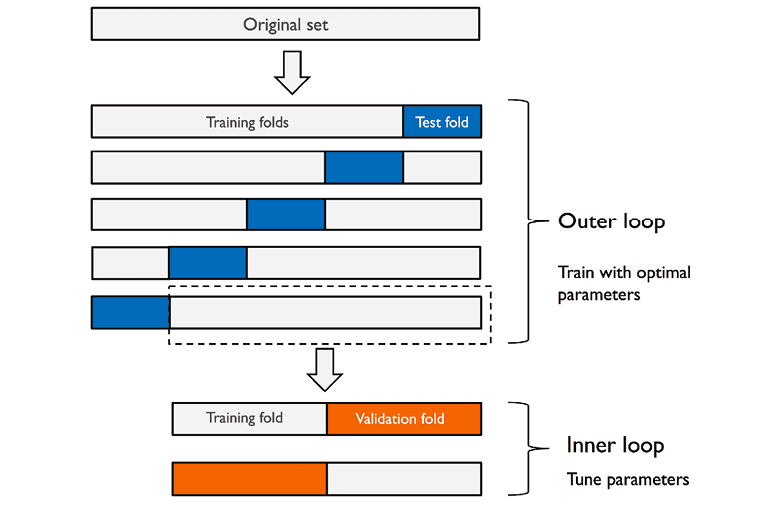

In [35]:
from sklearn.model_selection import cross_validate

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in num_vars if col != 'ejection_fraction']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_vars)
])

# Define model search spaces
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
ridge_nested = GridSearchCV(ridge_pipeline, ridge_params, cv=5)

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])
lasso_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
lasso_nested = GridSearchCV(lasso_pipeline, lasso_params, cv=5)

# Outer CV for nested evaluation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate nested Ridge
ridge_scores = cross_validate(ridge_nested, X, y, scoring=(
    'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), cv=outer_cv)

# Evaluate nested Lasso
lasso_scores = cross_validate(lasso_nested, X, y, scoring=(
    'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), cv=outer_cv)

# Function to format and print results
def summarize_nested_cv(name, scores):
    print(f"\n {name} Nested Cross-Validation Results (5-Fold):")
    mse = -scores['test_neg_mean_squared_error']
    mae = -scores['test_neg_mean_absolute_error']
    r2 = scores['test_r2']

    print(f"  ▸ MSE   : Mean = {mse.mean():.3f}, Std = {mse.std():.3f}")
    print(f"  ▸ MAE   : Mean = {mae.mean():.3f}, Std = {mae.std():.3f}")
    print(f"  ▸ R²    : Mean = {r2.mean():.3f}, Std = {r2.std():.3f}")

# Print summaries
summarize_nested_cv("Ridge", ridge_scores)
summarize_nested_cv("Lasso", lasso_scores)



 Ridge Nested Cross-Validation Results (5-Fold):
  ▸ MSE   : Mean = 77.203, Std = 6.083
  ▸ MAE   : Mean = 6.935, Std = 0.566
  ▸ R²    : Mean = 0.469, Std = 0.053

 Lasso Nested Cross-Validation Results (5-Fold):
  ▸ MSE   : Mean = 73.606, Std = 7.966
  ▸ MAE   : Mean = 6.786, Std = 0.612
  ▸ R²    : Mean = 0.493, Std = 0.072


Then need to re-tune on the whole training set to get the final best value of alpha

# Penalized Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Features and target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'ejection_fraction']]
y = df['DEATH_EVENT']

categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Logistic Regression without regularization (penalty='none')
logreg_none_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
])


# Logistic Regression (L2)
logreg_l2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])

logreg_l2_params = {'classifier__C': np.logspace(-3, 3, 50)}
logreg_l2_cv = GridSearchCV(logreg_l2_pipeline, logreg_l2_params, cv=5, scoring='roc_auc')

# Logistic Regression (L1)
logreg_l1_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

logreg_l1_params = {'classifier__C': np.logspace(-3, 3, 50)}
logreg_l1_cv = GridSearchCV(logreg_l1_pipeline, logreg_l1_params, cv=5, scoring='roc_auc')

# Fit models
logreg_l2_cv.fit(X_train, y_train)
logreg_l1_cv.fit(X_train, y_train)
logreg_none_pipeline.fit(X_train, y_train)

print("Best C for Logistic Regression (L2):", logreg_l2_cv.best_params_['classifier__C'])
print("Best C for Logistic Regression (L1):", logreg_l1_cv.best_params_['classifier__C'])

# Predictions
y_pred_none = logreg_none_pipeline.predict(X_test)
y_proba_none = logreg_none_pipeline.predict_proba(X_test)[:, 1]

y_pred_l2 = logreg_l2_cv.predict(X_test)
y_proba_l2 = logreg_l2_cv.predict_proba(X_test)[:, 1]

y_pred_l1 = logreg_l1_cv.predict(X_test)
y_proba_l1 = logreg_l1_cv.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_classification(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

# Compare metrics
metrics_classif_df = pd.DataFrame([
    evaluate_classification(y_test, y_pred_none, y_proba_none, 'LogReg None'),
    evaluate_classification(y_test, y_pred_l2, y_proba_l2, 'LogReg L2'),
    evaluate_classification(y_test, y_pred_l1, y_proba_l1, 'LogReg L1')
])

print("\nClassification Performance:")
print(metrics_classif_df)

# Coefficient Comparison
feature_names = logreg_l2_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'No Reg': [logreg_none_pipeline.named_steps['classifier'].intercept_[0]] +
            list(logreg_none_pipeline.named_steps['classifier'].coef_[0]),
    'L2': [logreg_l2_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l2_cv.best_estimator_.named_steps['classifier'].coef_[0]),
    'L1': [logreg_l1_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l1_cv.best_estimator_.named_steps['classifier'].coef_[0])
})

print("\nCoefficient Comparison:")
print(coef_df)

Best C for Logistic Regression (L2): 0.06866488450043001
Best C for Logistic Regression (L1): 0.1206792640639329

Classification Performance:
         Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  LogReg None      0.85       0.83    0.80      0.82     0.90
1    LogReg L2      0.83       0.86    0.72      0.78     0.90
2    LogReg L1      0.82       0.82    0.72      0.77     0.90

Coefficient Comparison:
                          Feature  No Reg    L2    L1
0                       Intercept   -1.02 -0.51 -0.92
1                        num__age    0.62  0.35  0.23
2   num__creatinine_phosphokinase    0.05  0.04  0.00
3          num__ejection_fraction   -0.43 -0.30 -0.08
4                  num__platelets   -0.18 -0.06  0.00
5           num__serum_creatinine    0.23  0.22  0.00
6               num__serum_sodium    0.03  0.02  0.00
7                        num__bmi    0.57  0.31  0.47
8                       num__time   -1.73 -0.92 -1.06
9                  cat__anaemia_1   -0.24

# CV for KNN

Best k: 15 with macro-f1: 0.9799


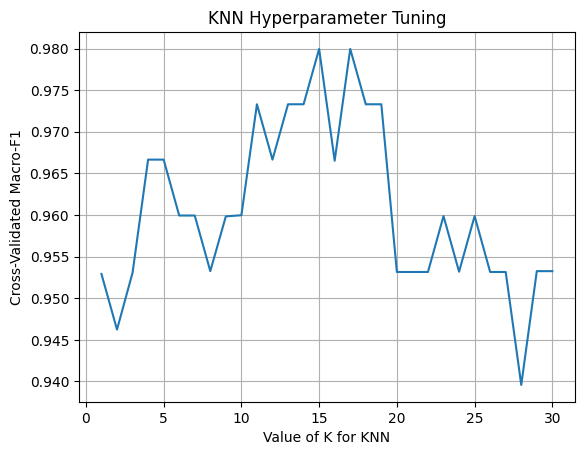

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Set up stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # keeps y distribution constant among folds

# Evaluate range of k
k_range = range(1, 31)
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, cv=cv, scoring='f1_macro').mean()
          for k in k_range]

# Find best k
best_score_idx = np.argmax(scores)
best_k = k_range[best_score_idx]
print(f"Best k: {best_k} with macro-f1: {scores[best_score_idx]:.4f}")

# Train final model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X, y)

# Plot results
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Macro-F1')
plt.title('KNN Hyperparameter Tuning')
plt.grid(True)
plt.show()
